In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [2]:
def ghb_jk_teff(jk,feh):
    '''
    Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009

    Input:
    -----
        jk: J - K color
    '''
    b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])

    theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*feh)+b[4]*feh+b[5]*(feh**2)
    teff = 5040/theta_eff
    self.ghb_teff = teff
    return teff

def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOGEE

In [122]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-122-c45f30211bba>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


In [5]:
# # https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf

# cn = dr17['FPARAM'][:,4]-dr17['FPARAM'][:,5]
# dt = dr17['TEFF_SPEC'] - (4400.+552.6*(dr17['LOGG_SPEC']-2.5)-324.6*dr17['FPARAM'][:,3])

# rc = dr17[np.where((dr17['FPARAM'][:,1]>2.38)&(dr17['FPARAM'][:,1]<3.5)&
#                    (cn>0.04-0.46*dr17['FPARAM'][:,3]-0.0028*dt))]

# rgb = dr17[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
#                     (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]

# rgb_salfeh = salfeh[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
#                     (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
# rgb_salfeh_err = salfeh_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
#                     (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
# rgb_apoafe = apoafe[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
#                     (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
# rgb_apoafe_err = apoafe_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
#                     (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]


# # Get rid of stars with any ASPCAP flag and high extinction
# rgb_salfeh[np.where((rgb['ASPCAPFLAG']==0))]
# rgb_salfeh_err[np.where((rgb['ASPCAPFLAG']==0))]
# rgb_apoafe[np.where((rgb['ASPCAPFLAG']==0))]
# rgb_apoafe_err[np.where((rgb['ASPCAPFLAG']==0))]
# rgb = rgb[np.where((rgb['ASPCAPFLAG']==0))]

# APOKASC

In [231]:
# from astropy.io import ascii

# kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
# kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

# # xmatch APOKASC Catalogs
# _, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
# k672 = kasc672[k672idx]
# k3 = kasc3[k3idx]

# # xmatch APOKASC with DR17
# _, k3_idx, dr17_idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

# k672 = k672[k3_idx]
# k3 = k3[k3_idx]
# kdr17 = dr17[dr17_idx]

# # Get RGB stars in APOKASC
# ageevs = np.where((k3['IntAge']>-10.)&(k672['APOKASC3_CONS_EVSTATES']==1.0))#&
# #                   (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

# k672 = k672[ageevs]
# k3 = k3[ageevs]
# kdr17 = dr17[ageevs]

In [235]:
# len(np.squeeze(np.where((kdr17['APOGEE_ID']==k3['2MASSID'])==False)))/len(kdr17)

1.0

<ipython-input-309-cf6e558f5630>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


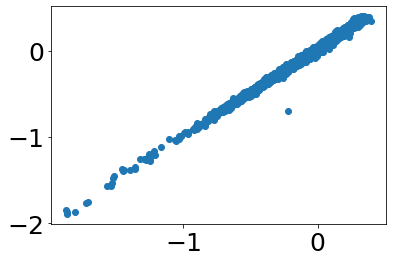

In [309]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0))#&
#                   (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

# xmatch dr16
_, k3dr16_idx, dr16_idx = np.intersect1d(k3dr17['2MASSID'],dr16['APOGEE_ID'],return_indices=True)

k672dr16 = k672dr17[k3dr16_idx]
k3dr16 = k3dr17[k3dr16_idx]
kdr17_16 = kdr17[k3dr16_idx]

kdr16 = dr16[dr16_idx]

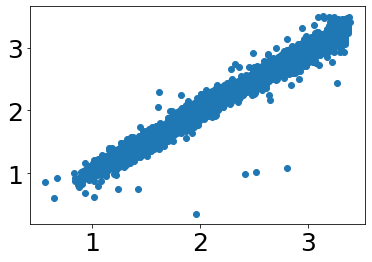

In [310]:
plt.scatter(k3dr16['Logg'],kdr16['LOGG'])

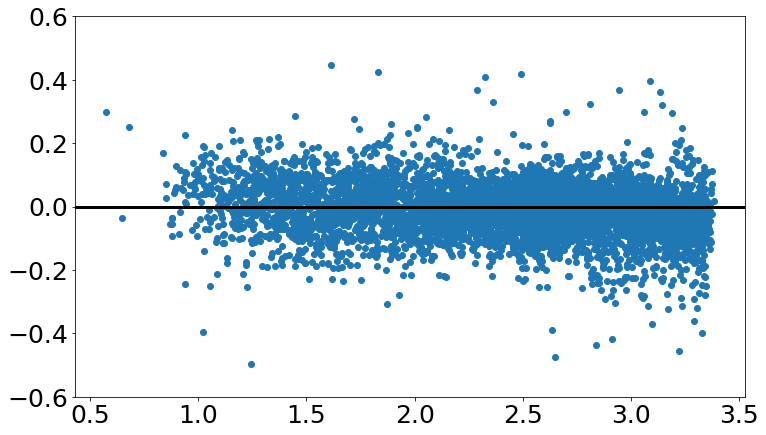

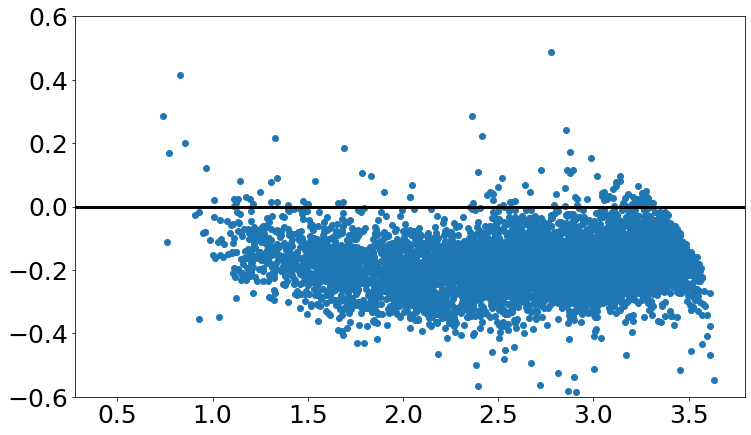

In [315]:
plt.figure(figsize=[12,7])
plt.scatter(k3dr16['Logg'],kdr16['LOGG']-k3dr16['Logg'])
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-0.6,0.6)
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(kdr16['FPARAM'][:,1],k3dr16['Logg']-kdr16['FPARAM'][:,1])
plt.axhline(0.0,c='k',lw=3.0)
plt.ylim(-0.6,0.6)
plt.show()

In [316]:
k3dr17.columns

<TableColumns names=('KICID','Mass','Logg','Fe/H','Al/Fe','Teff','C/N','M_err','Logg_err','Fe/H_err','Al/Fe_err','Teff_err','2MASSID','IntTeff','IntML','IntAge','IntC12','IntC13','IntN14','IntXsurf')>

# Gaia EDR3

In [238]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

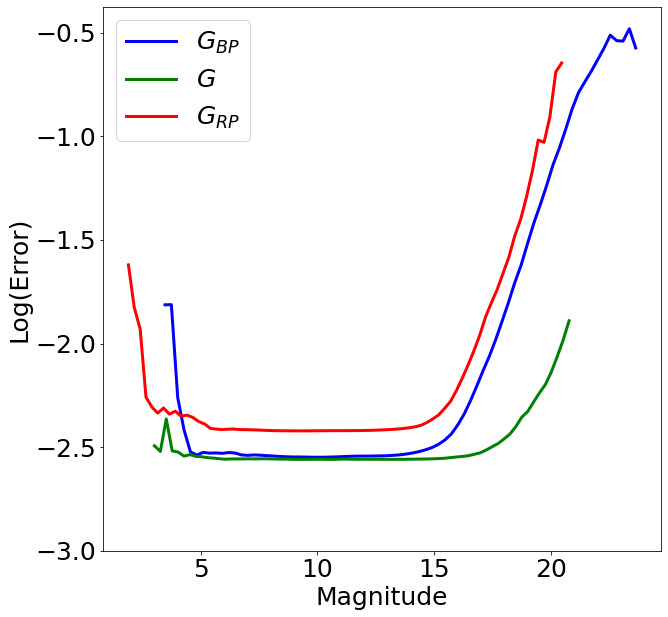

In [317]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

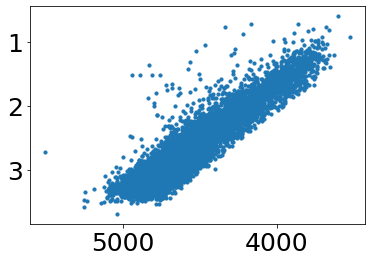

In [318]:
plt.scatter(kdr17['FPARAM'][:,0],kdr17['FPARAM'][:,1],s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

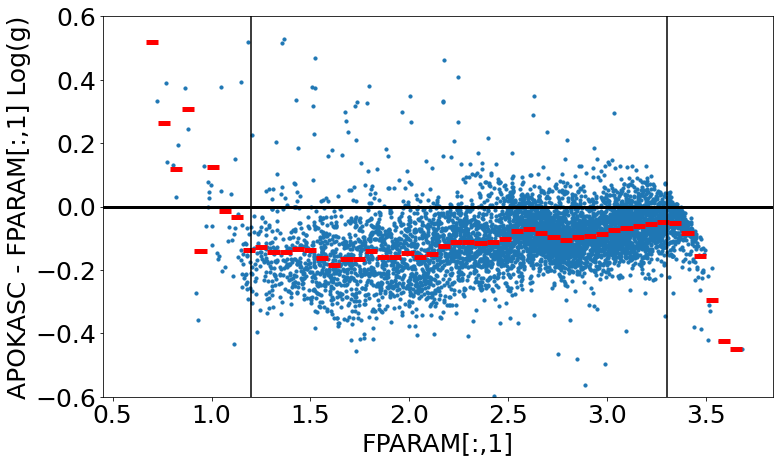

In [323]:
np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True))

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.axhline(0.0,c='k',lw=3.0)

plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=5.)

plt.axvline(1.2,c='k')
plt.axvline(3.3,c='k')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [ ]:
one panel with resid vs logg and best line fit
second pan resid vs [mh] with appliued logg corr best fit quad in feh
third final resid plot vs logg print final rmse

use logg and teff find iso point 

In [329]:
def dlogg_logg_cal(lgg,lgg_m,lgg_b):
    '''
    Calculate the correction to the uncalibrated Log(g) [FPARAM[:,1]] to better match APOKASC 3. 
    In addition a quadratic correction as a function of the uncalibrated [M/H] [FPARAM[:,3]] needs 
    to be applied after this one.
    
    Inputs:
    ------
        lgg: uncalibrated Log(g) value
        lgg_m: slope of line
        lgg_b: y intercept line
        
    Output:
    ------
        dlogg: correction to be added to the uncalibrate Log(g) 
    '''
    dlogg = lgg_m*lgg+lgg_b
    return dlogg

cutlogg = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True)&(kdr17['FPARAM'][:,1]>1.2)&(kdr17['FPARAM'][:,1]<3.3))

popt_dlogg_logg, _ = curve_fit(dlogg_logg_cal,kdr17['FPARAM'][:,1][cutlogg],
                               (k3dr17['Logg']-kdr17['FPARAM'][:,1])[cutlogg])

param_labels = np.array(['lgg_m','lgg_b'])
for i in range(len(param_labels)):
    print('{}: {}'.format(param_labels[i],popt_dlogg_logg[i]))
    
logg_logg = kdr17['FPARAM'][:,1] + dlogg_logg_cal(kdr17['FPARAM'][:,1],*popt_dlogg_logg)

lgg_m: 0.05817596053988467
lgg_b: -0.2501396759045989


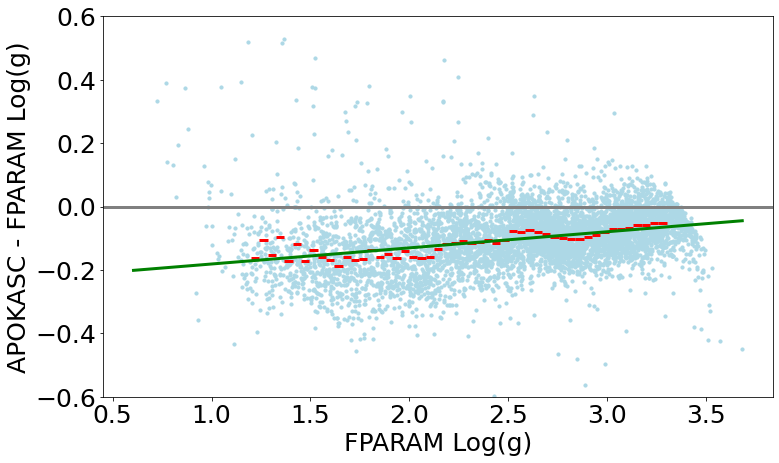

In [445]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (kdr17['FPARAM'][:,1]>1.2)&(kdr17['FPARAM'][:,1]<3.3))
meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)
cens = edgs[:-1]+np.median(np.diff(edgs))/2

fincut2 = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))

logg_logg_corr = np.poly1d(np.polyfit(cens[fincut2],meds[fincut2],1))

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10,c='lightblue')

plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=3.)

xs_fparam1 = np.linspace(min(kdr17['FPARAM'][:,1]),max(kdr17['FPARAM'][:,1]))

plt.plot(xs_fparam1,logg_logg_corr(xs_fparam1),c='green',lw=3.0)

plt.axhline(0.0,c='grey',lw=3.0)

# plt.axvline(1.2,c='k')
# plt.axvline(3.3,c='k')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM Log(g)')
plt.ylabel(r'APOKASC - FPARAM Log(g)')
plt.show()

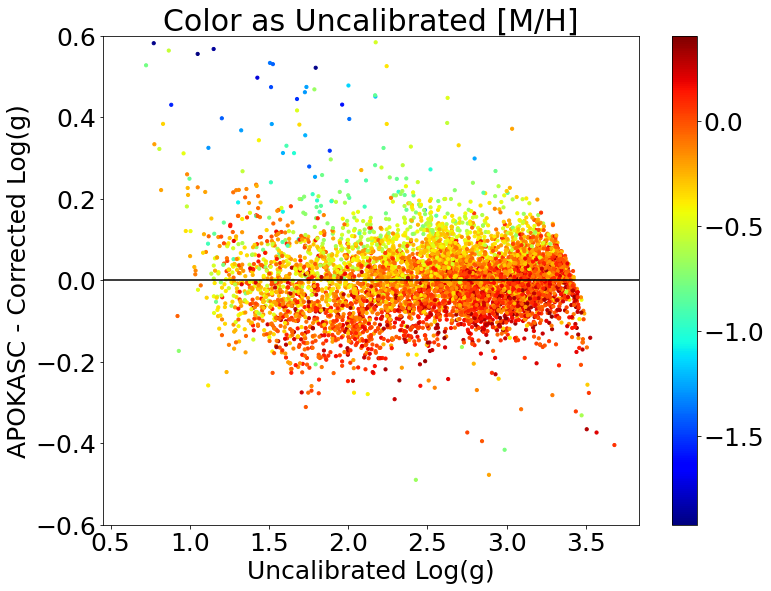

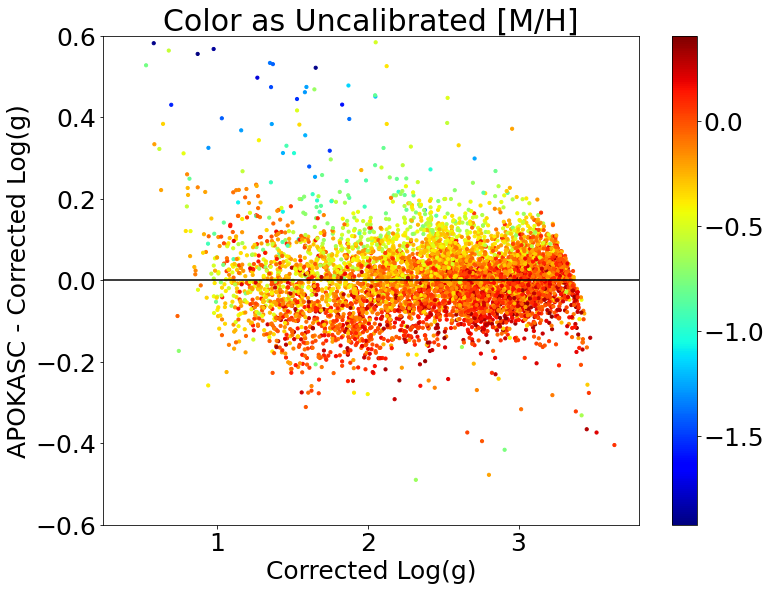

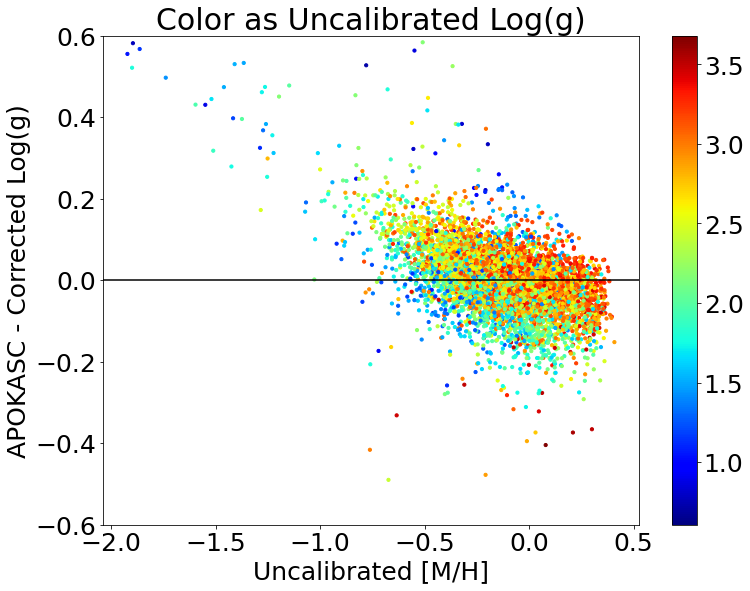

In [425]:
plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,3],cmap='jet',s=10)
plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Uncalibrated Log(g)')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1]),
            k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,3],cmap='jet',s=10)
plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated [M/H]')
plt.xlabel(r'Corrected Log(g)')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            c=kdr17['FPARAM'][:,1],cmap='jet',s=10)
plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

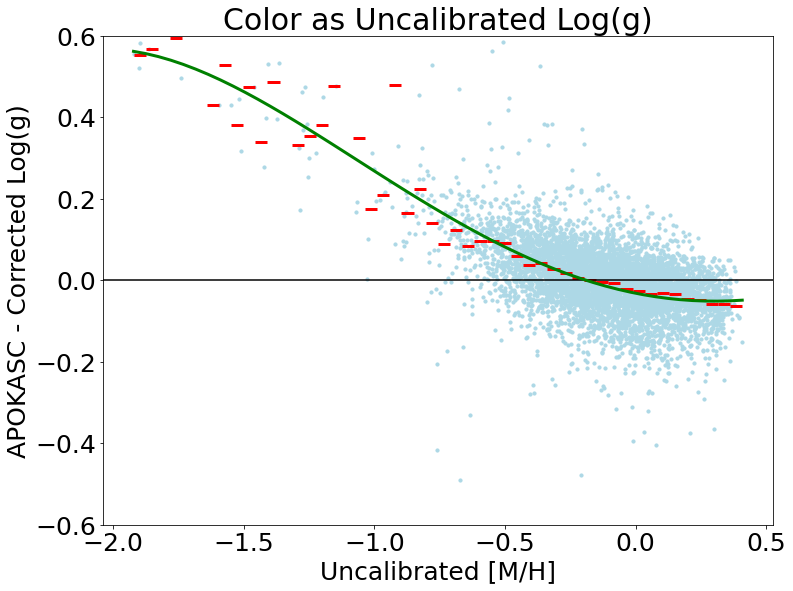

In [448]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,3])==True)&
                  (np.isfinite(k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])))==True))
meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,3][fincut],
                               (k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])))[fincut],bins=50)

cens = edgs[:-1]+np.median(np.diff(edgs))/2

plt.figure(figsize=[12,9])

plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=3.)

plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(kdr17['FPARAM'][:,1]+logg_logg_corr(kdr17['FPARAM'][:,1])),
            s=10,c='lightblue')
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.title(r'Color as Uncalibrated Log(g)')
plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC - Corrected Log(g)')

fincut2 = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))
logg_feh_corr = np.poly1d(np.polyfit(cens[fincut2],meds[fincut2],4))

xs_fparam3 = np.linspace(min(kdr17['FPARAM'][:,3]),max(kdr17['FPARAM'][:,3]))
plt.plot(xs_fparam3,logg_feh_corr(xs_fparam3),c='green',lw=3.0)

plt.show()

In [ ]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (kdr17['FPARAM'][:,1]>1.2)&(kdr17['FPARAM'][:,1]<3.3))
meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)
cens = edgs[:-1]+np.median(np.diff(edgs))/2

fincut2 = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))

logg_feh_corr = np.poly1d(np.polyfit(cens[fincut2],meds[fincut2],1))

In [422]:
# np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True))

# meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

# plt.figure(figsize=[12,9])
# plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
# plt.axhline(0.0,c='k',lw=1.0)

# # plt.hlines(meds,edgs[:-1],edgs[1:],colors='red',lw=3.)
# plt.plot(kdr17['FPARAM'][:,1],logg_logg-kdr17['FPARAM'][:,1],c='tab:red',lw=3.0)

# # plt.axvline(1.2,c='k',ls='--')
# # plt.axvline(3.3,c='k',ls='--')

# plt.ylim(-0.6,0.6)

# # plt.grid()

# plt.xlabel(r'Uncalibrated ASPCAP Log(g)')
# plt.ylabel(r'APOKASC - Uncalibrated ASPCAP Log(g)')
# plt.show()

In [426]:
# plt.figure(figsize=[12,9])
# plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-(logg_logg),c=kdr17['FPARAM'][:,3],cmap='jet',s=10)
# plt.colorbar()
# plt.ylim(-0.6,0.6)
# plt.axhline(0.0,c='k')

# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Uncalibrated Log(g)')
# plt.ylabel(r'APOKASC - Corrected Log(g)')
# plt.show()

# plt.figure(figsize=[12,9])
# plt.scatter(logg_logg,k3dr17['Logg']-(logg_logg),c=kdr17['FPARAM'][:,3],cmap='jet',s=10)
# plt.colorbar()
# plt.ylim(-0.6,0.6)
# plt.axhline(0.0,c='k')

# plt.title(r'Color as Uncalibrated [M/H]')
# plt.xlabel(r'Corrected Log(g)')
# plt.ylabel(r'APOKASC - Corrected Log(g)')
# plt.show()

# plt.figure(figsize=[12,9])
# plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(logg_logg),c=kdr17['FPARAM'][:,1],cmap='jet',s=10)
# plt.colorbar()
# plt.ylim(-0.6,0.6)
# plt.axhline(0.0,c='k')

# plt.title(r'Color as Uncalibrated Log(g)')
# plt.xlabel(r'Uncalibrated [M/H]')
# plt.ylabel(r'APOKASC - Corrected Log(g)')
# plt.show()

In [386]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,3])==True)&(np.isfinite(k3dr17['Logg']-(logg_logg))==True))

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,3][fincut],(k3dr17['Logg']-(logg_logg))[fincut],'median',bins=50)
cens = edgs[:-1]+np.median(np.diff(edgs))/2.

fincut2 = np.where((np.isfinite(meds)==True)&(np.isfinite(cens)==True))

test_poly = np.poly1d(np.polyfit(cens[fincut2],meds[fincut2],1))
print(test_poly)

 
-0.3059 x - 0.03184


In [388]:
def dlogg_mh_cal(mh,mh_m,mh_b):
    '''
    Calculate the correction to the uncalibrated Log(g) [FPARAM[:,1]] with a linear correction in 
    logg already applied.
    
    Inputs:
    ------
        mh: uncalibrated [M/H] value
        mh_m: slope of line
        mh_b: y intercept line
        
    Output:
    ------
        dlogg: correction to be added to the uncalibrate Log(g) with a linear correction in logg 
        already applied 
    '''
    dlogg = mh_m*mh+mh_b
    return dlogg

cutlogg = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True)&(kdr17['FPARAM'][:,1]>1.2)&(kdr17['FPARAM'][:,1]<3.3))

popt_dlogg_mh, _ = curve_fit(dlogg_mh_cal,kdr17['FPARAM'][:,3][cutlogg],(k3dr17['Logg']-(logg_logg))[cutlogg])

param_labels = np.array(['mh_m','mh_b'])
for i in range(len(param_labels)):
    print('{}: {}'.format(param_labels[i],popt_dlogg_mh[i]))
    
logg_mh = logg_logg + dlogg_mh_cal(kdr17['FPARAM'][:,3],*popt_dlogg_mh)

mh_m: -0.18922783112953645
mh_b: -0.023675504656628932


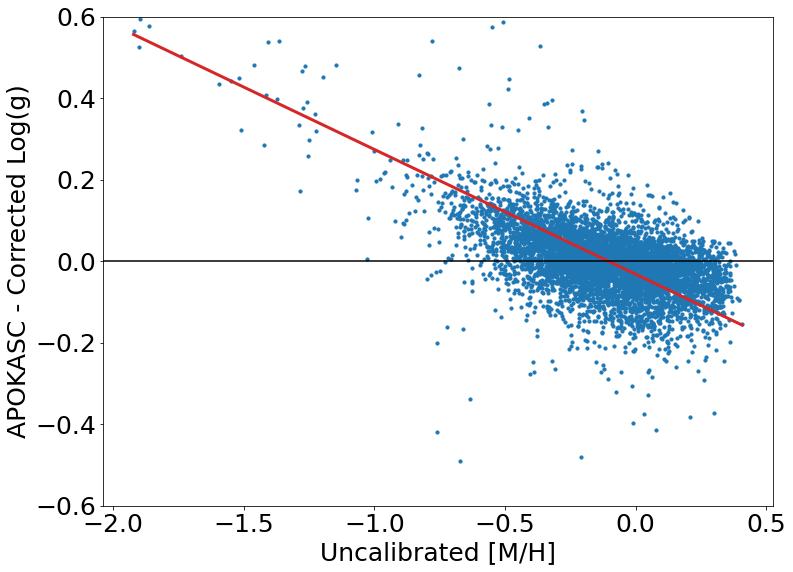

In [399]:
plt.figure(figsize=[12,9])
plt.scatter(kdr17['FPARAM'][:,3],k3dr17['Logg']-(logg_logg),s=10)
test_mh = np.linspace(min(kdr17['FPARAM'][:,3]),max(kdr17['FPARAM'][:,3]))
plt.plot(test_mh,test_poly(test_mh),c='tab:red',lw=3.0)
# plt.plot(kdr17['FPARAM'][:,3],logg_mh-kdr17['FPARAM'][:,1],c='tab:red',lw=3.0)

# plt.plot(kdr17['FPARAM'][:,3],k3dr17['Logg']-(logg_mh-kdr17['FPARAM'][:,1]),c='tab:red',lw=3.0)
# plt.plot(kdr17['FPARAM'][:,1],logg_mh-kdr17['FPARAM'][:,1],c='tab:red',lw=3.0)
# plt.plot(cens,test_poly(cens),c='r',lw=3.0)
# plt.colorbar()
plt.ylim(-0.6,0.6)
plt.axhline(0.0,c='k')

plt.xlabel(r'Uncalibrated [M/H]')
plt.ylabel(r'APOKASC - Corrected Log(g)')
plt.show()

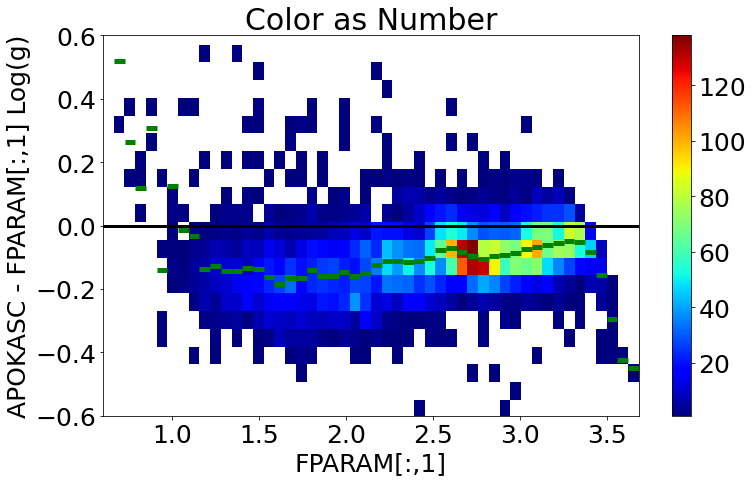

In [250]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True))

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][fincut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,1][fincut],'count',bins=50)
    
ret.statistic[ret.statistic == 0.0] = np.nan

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
# plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.title(r'Color as Number')
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

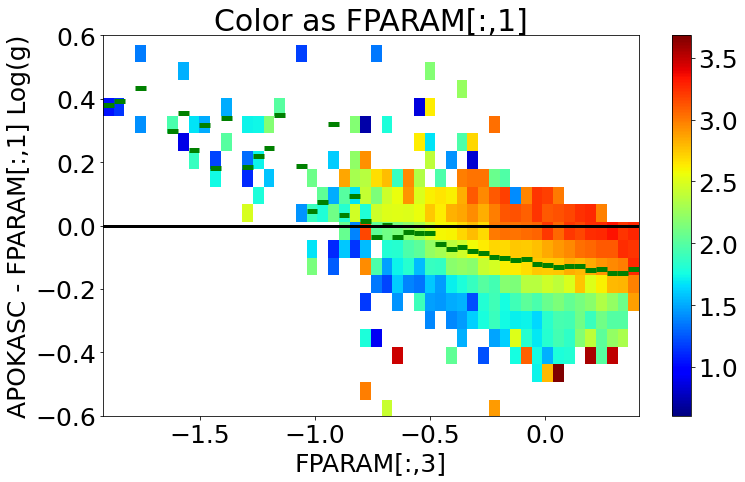

In [252]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

ret = binned_statistic_2d(kdr17['FPARAM'][:,3][fincut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,1][fincut],'median',bins=50)
    
ret.statistic[ret.statistic == 0.0] = np.nan

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,3][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')
plt.colorbar()

plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.title(r'Color as FPARAM[:,1]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [254]:
# fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(kdr17['Logg'])==True)&
#                   (np.isfinite(kdr17['FPARAM'][:,3])==True))

# ret = binned_statistic_2d(kdr17['FPARAM'][:,1][fincut],
#                           (kdr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,3][fincut],'median',bins=50)
    
# ret.statistic[ret.statistic == 0.0] = np.nan

# meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(kdr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

# plt.figure(figsize=[12,7])
# plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet')
# plt.colorbar()

# plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

# plt.axhline(0.0,c='k',lw=3.0)

# plt.axvline(1.2795,c='k',lw=3.0)

# plt.ylim(-0.6,0.6)

# plt.title(r'Color as FPARAM[:,3]')
# plt.xlabel(r'FPARAM[:,1]')
# plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
# plt.show()

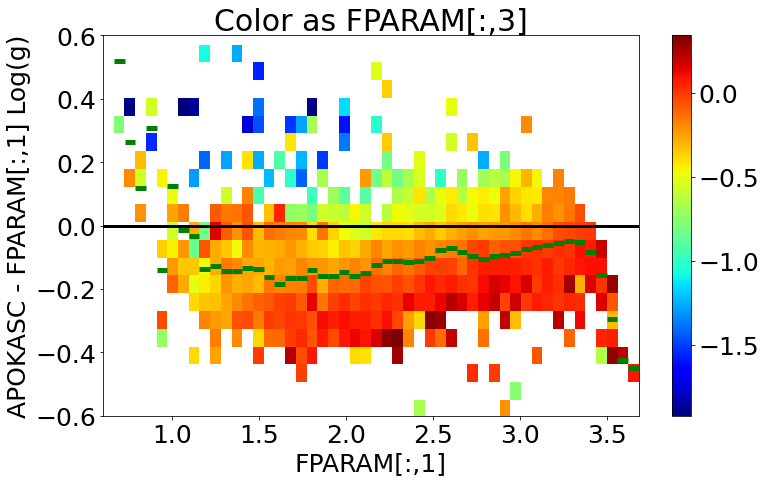

In [255]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True))

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][fincut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,3][fincut],'median',bins=50)
    
ret.statistic[ret.statistic == 0.0] = np.nan

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
# plt.scatter(kdr17['FPARAM'][:,1],k3dr17['Logg']-kdr17['FPARAM'][:,1],s=10)
plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

plt.colorbar()

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.title(r'Color as FPARAM[:,3]')
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [ ]:
# def piecewise_linear(x, x0, x1, b, k1, k2, k3):
#     condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
#     funclist = [lambda x: k1*x + b, lambda x: k1*x + b + k2*(x-x0), lambda x: k1*x + b + k2*(x-x0) + k3*(x - x1)]
#     return np.piecewise(x, condlist, funclist)

# p , e = optimize.curve_fit(piecewise_linear, x, y)

# xd = np.linspace(-30, 30, 1000)
# plt.plot(x, y, "o")
# plt.plot(xd, piecewise_linear(xd, *p))

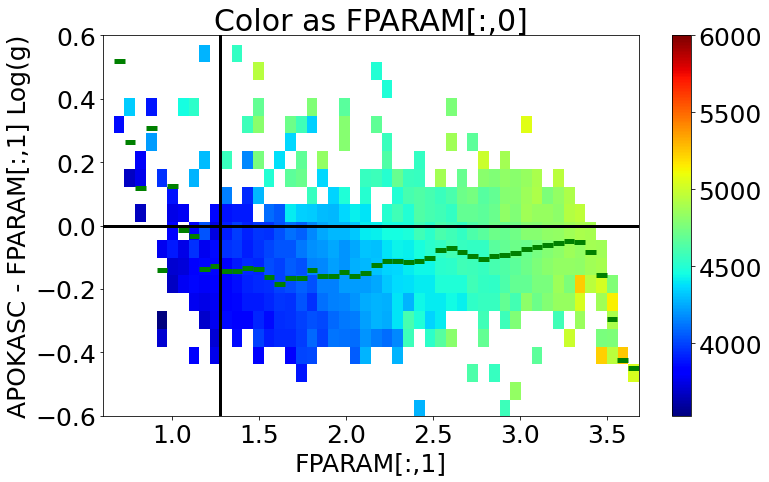

In [256]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

ret = binned_statistic_2d(kdr17['FPARAM'][:,1][fincut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,0][fincut],'median',bins=50)
    
ret.statistic[ret.statistic == 0.0] = np.nan

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmax=6000)
plt.colorbar()

plt.hlines(meds, edgs[:-1], edgs[1:], colors='green', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.axvline(1.2795,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.title(r'Color as FPARAM[:,0]')
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [265]:
logg_after_dlogg_lin

array([2.8383362, 3.2659743, 2.8563807, ..., 2.7655337, 1.8217051,
       2.305979 ], dtype=float32)

[a,b] [ 0.05817596 -0.25013968]


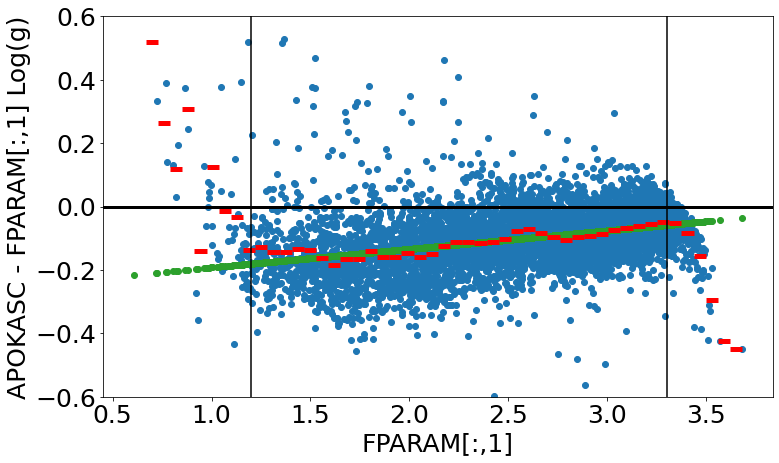

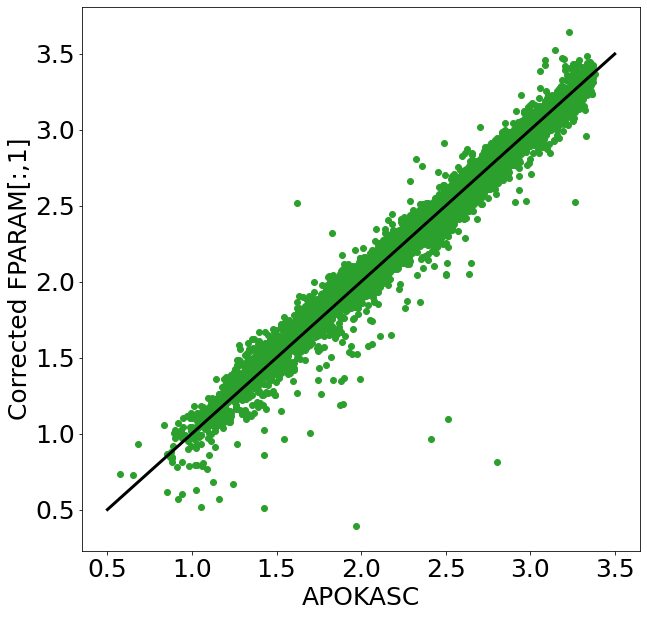

In [284]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

logg_cut = np.where((kdr17['FPARAM'][:,1][fincut]>1.2)&(kdr17['FPARAM'][:,1][fincut]<3.3))

def dlogg_lin(lgg,a,b):
    '''
    linear logg correction
    '''
    return a*lgg+b
    
popt_dlogg_lin, _ = curve_fit(dlogg_lin,kdr17['FPARAM'][:,1][fincut][logg_cut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut][logg_cut])
print(r'[a,b]',popt_dlogg_lin)

logg_lin_corr = dlogg_lin(kdr17['FPARAM'][:,1],*popt_dlogg_lin)

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

###
plt.figure(figsize=[12,7])

plt.scatter(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut])
plt.scatter(kdr17['FPARAM'][:,1][fincut],logg_lin_corr[fincut],c='tab:green')

plt.hlines(meds, edgs[:-1], edgs[1:], colors='red', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.axvline(1.2,c='k')
plt.axvline(3.3,c='k')

plt.ylim(-0.6,0.6)

plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

### 
plt.figure(figsize=[10,10])

plt.scatter(k3dr17['Logg'][fincut],(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],c='tab:green')

plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)

plt.xlabel(r'APOKASC')
plt.ylabel(r'Corrected FPARAM[:,1]')
plt.show()

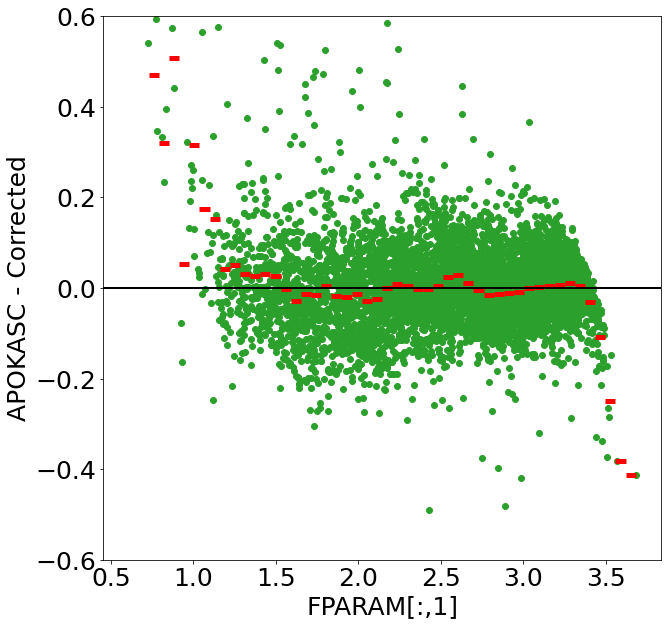

In [293]:
plt.figure(figsize=[10,10])

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],bins=50)

plt.scatter(kdr17['FPARAM'][:,1][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],c='tab:green')
plt.axhline(0.0,c='k',lw=2)

plt.hlines(meds, edgs[:-1], edgs[1:], colors='red', lw=5.)

plt.ylim(-0.6,0.6)

plt.ylabel(r'APOKASC - Corrected')
plt.xlabel(r'FPARAM[:,1]')
plt.show()

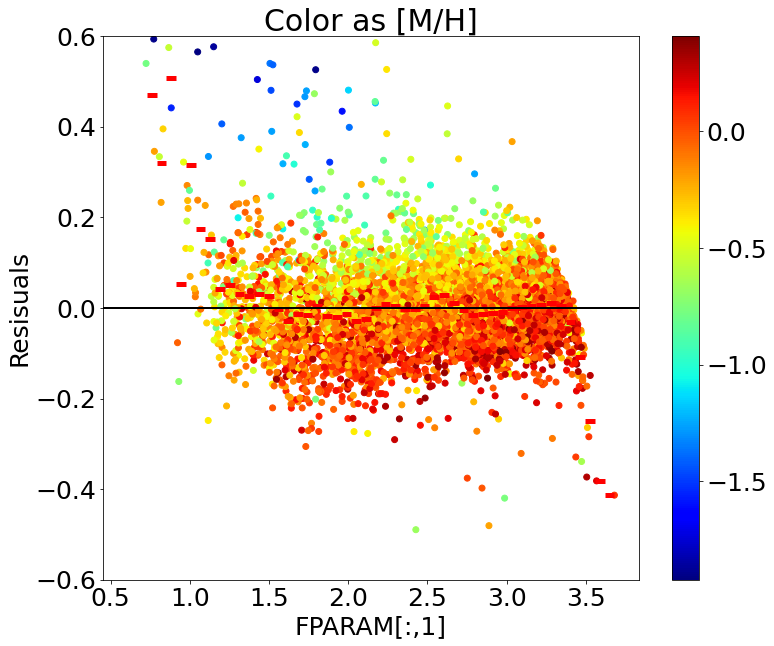

In [288]:
plt.figure(figsize=[12,10])

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],bins=50)

plt.scatter(kdr17['FPARAM'][:,1][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],c=kdr17['FPARAM'][:,3][fincut],cmap='jet')
plt.axhline(0.0,c='k',lw=2)

plt.hlines(meds, edgs[:-1], edgs[1:], colors='red', lw=5.)

plt.ylim(-0.6,0.6)

plt.colorbar()

plt.title(r'Color as [M/H]')
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'Resisuals')
plt.show()

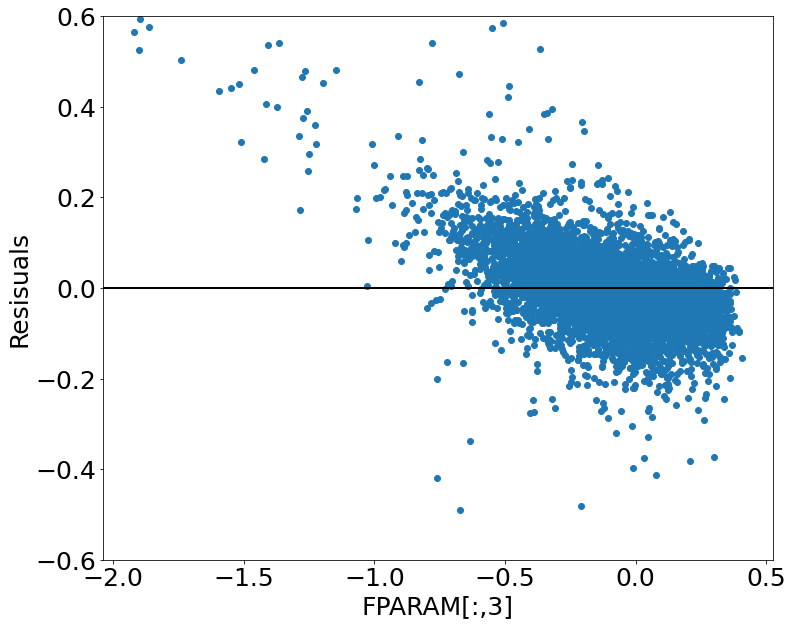

In [290]:
plt.figure(figsize=[12,10])

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],bins=50)

plt.scatter(kdr17['FPARAM'][:,3][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut],cmap='jet')
plt.axhline(0.0,c='k',lw=2)

# plt.hlines(meds, edgs[:-1], edgs[1:], colors='red', lw=5.)

plt.ylim(-0.6,0.6)

# plt.colorbar()

# plt.title(r'Color as [M/H]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'Resisuals')
plt.show()

[a,b,c] [ 0.12213092 -0.13670406 -0.02533025]


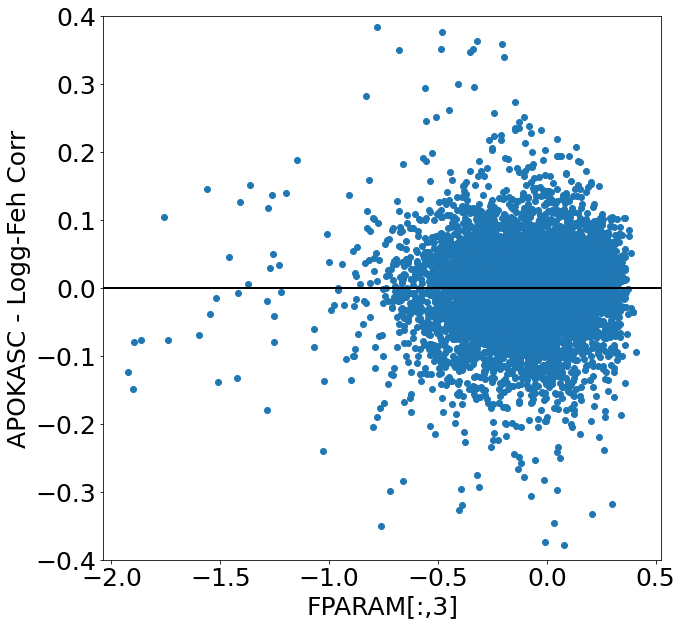

In [304]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

logg_cut = np.where((kdr17['FPARAM'][:,1][fincut]>1.2)&(kdr17['FPARAM'][:,1][fincut]<3.3))

def dlogg_lin_feh(feh,a,b,c):
    '''
    linear logg correction
    '''
    return a*feh**2+b*feh+c
    
popt_dlogg_lin_feh, _ = curve_fit(dlogg_lin_feh,kdr17['FPARAM'][:,3][fincut],
                              k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut])
print(r'[a,b,c]',popt_dlogg_lin_feh)

logg_lin_feh_corr = dlogg_lin_feh(kdr17['FPARAM'][:,3],*popt_dlogg_lin_feh)

#meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

###
plt.figure(figsize=[10,10])
plt.scatter(kdr17['FPARAM'][:,3][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr+logg_lin_feh_corr)[fincut],cmap='jet')
plt.axhline(0.0,c='k',lw=2)


plt.ylim(-0.4,0.4)

# plt.title(r'Color as [M/H]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Logg-Feh Corr')
plt.show()

In [ ]:
one panel with resdi vs logg and best line fit
second pan resid vs [mh] with appliued logg corr best fit quad in feh
third final resid plot vs logg print final rmse

use logg and teff find iso point 

[a,b,c,d] [ 0.00355077  0.12264442 -0.14771733 -0.05085515]


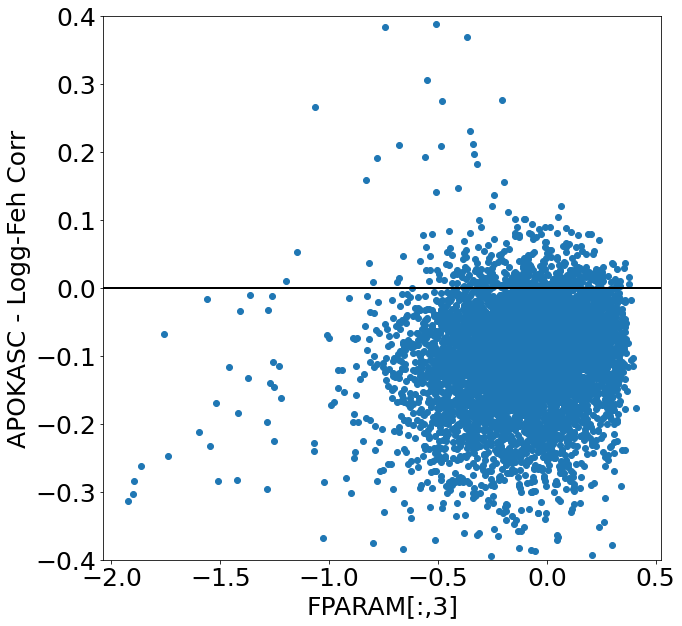

In [307]:
def dlogg(X,a,b,c,d):
    logg, mh = X
    return a*logg**2+b*mh**2+c*mh+d

popt_dlogg, _ = curve_fit(dlogg,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                          k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_lin_corr)[fincut])
print(r'[a,b,c,d]',popt_dlogg)

logg_corr = dlogg((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]),*popt_dlogg)

#meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,1][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

###
plt.figure(figsize=[10,10])
plt.scatter(kdr17['FPARAM'][:,3][fincut],
            k3dr17['Logg'][fincut]-(kdr17['FPARAM'][:,1]+logg_corr)[fincut],cmap='jet')
plt.axhline(0.0,c='k',lw=2)


plt.ylim(-0.4,0.4)

# plt.title(r'Color as [M/H]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - Logg-Feh Corr')
plt.show()

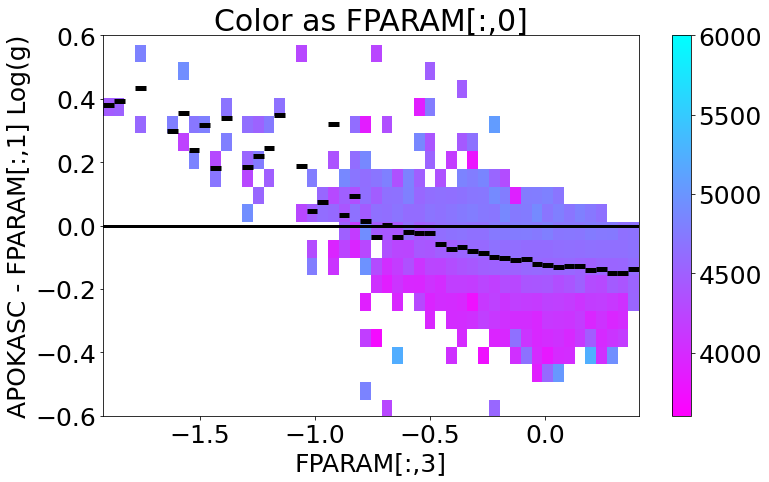

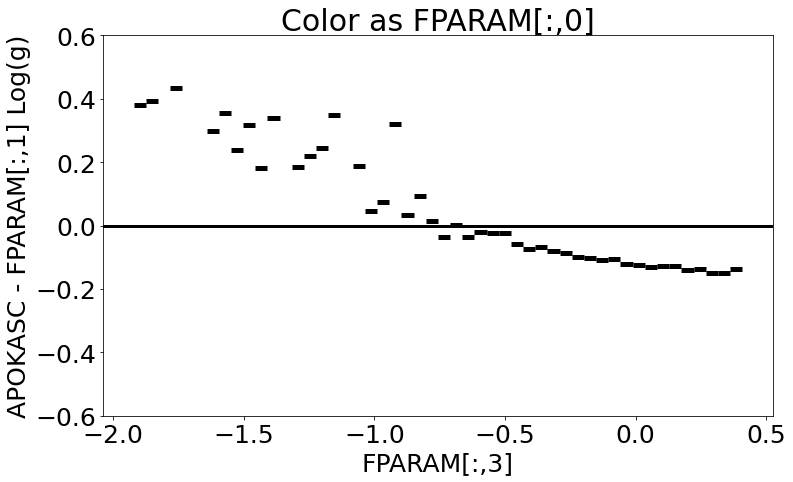

In [258]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3dr17['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

ret = binned_statistic_2d(kdr17['FPARAM'][:,3][fincut],
                          (k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],kdr17['FPARAM'][:,0][fincut],'median',bins=50)
    
ret.statistic[ret.statistic == 0.0] = np.nan

meds,edgs,_ = binned_statistic(kdr17['FPARAM'][:,3][fincut],(k3dr17['Logg']-kdr17['FPARAM'][:,1])[fincut],bins=50)

plt.figure(figsize=[12,7])
plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='cool_r',vmax=6000)
plt.colorbar()

plt.hlines(meds, edgs[:-1], edgs[1:], colors='k', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.6,0.6)

plt.title(r'Color as FPARAM[:,0]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

###
plt.figure(figsize=[12,7])

plt.hlines(meds, edgs[:-1], edgs[1:], colors='k', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)


plt.ylim(-0.6,0.6)

plt.title(r'Color as FPARAM[:,0]')
plt.xlabel(r'FPARAM[:,3]')
plt.ylabel(r'APOKASC - FPARAM[:,1] Log(g)')
plt.show()

In [212]:
fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

def dlogg(X,mh0,mh1,a,b,c,d):
    '''
    
    '''
    logg, mh = X
    condlist = [mh < mh0, (mh >= mh0) & (mh < mh1), mh >= mh1]
    funclist = [lambda y: a*y + b + c*logg,lambda y: d*y + b + (a-d)*mh0 +c*logg,
                lambda y: d*mh1 + b + (a-d)*mh0 + c*logg]
    return np.piecewise(mh, condlist, funclist)
    
popt_dlogg, _ = curve_fit(dlogg,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                          (k3['Logg']-kdr17['FPARAM'][:,1])[fincut],
                          p0=(-1.0,0.0,1.0,1.0,-1.0,-1.0))
print(popt_dlogg)

# xd = np.linspace(-30, 30, 1000)
# plt.plot(x, y, "o")
# plt.plot(xd, piecewise_linear(xd, *p))  

ValueError: operands could not be broadcast together with shapes (354,) (5975,) 

In [225]:
def dlogg(X,mh0,mh1,a,b,c,d):
    logg, mh = X
    return np.piecewise(mh,[mh < mh0,(mh >= mh0)&(mh < mh1),mh >= mh1],
                        [lambda x: a*x + b + c*logg, 
                         lambda x: d*x + b + (a-d)*mh0 +c*logg,
                         lambda x: d*mh1 + b + (a-d)*mh0 + c*logg])

fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

param_labels = np.array(['mh0','mh1','a','b','c','d'])
popt, _ = curve_fit(dlogg,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                        (k3['Logg']-kdr17['FPARAM'][:,1])[fincut])#,p0=[-1.0,0.0,1.0,-1.0,1.0,1.0])

print('Fit Parameters:')
for i in range(6):
    print(r'{} = {:.5f}'.format(param_labels[i],popt[i]))

Fit Parameters:
mh0 = 1.00000
mh1 = 1.00000
a = -0.00812
b = 2.43938
c = -0.99864
d = 1.00000


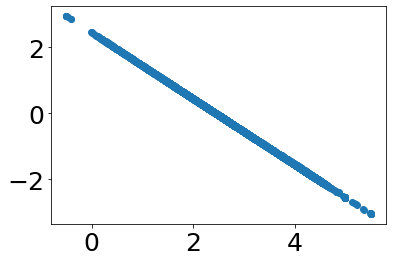

In [226]:
plt.scatter(kdr17['FPARAM'][:,1][fincut],
            dlogg((kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),*popt))

In [224]:
def dlogg(X,a,b,c,d):
    logg, mh = X
    return np.piecewise(mh,[mh < -1.0,(mh >= -1.0)&(mh < 0.0),mh >= 0.0],
                        [lambda x: a*x + b + c*logg, 
                         lambda x: d*x + b + (a-d)*mh0 +c*logg,
                         lambda x: d*mh1 + b + (a-d)*mh0 + c*logg])

fincut = np.where((np.isfinite(kdr17['FPARAM'][:,1])==True)&(np.isfinite(k3['Logg'])==True)&
                  (np.isfinite(kdr17['FPARAM'][:,3])==True))

param_labels = np.array(['a','b','c','d'])
popt, _ = curve_fit(dlogg,(kdr17['FPARAM'][:,1][fincut],kdr17['FPARAM'][:,3][fincut]),
                        (k3['Logg']-kdr17['FPARAM'][:,1])[fincut],p0=[1.0,-1.0,1.0,1.0])

print('Fit Parameters:')
for i in range(6):
    print(r'{} = {:.5f}'.format(param_labels[i],popt[i]))

ValueError: operands could not be broadcast together with shapes (354,) (5975,) 